# Kling–Gupta Efficiency (KGE)
In this notebook, we will explore the Kling-Gupta Efficiency (KGE) which is widely used to evaluate the performance of hydrological models. KGE is a performance metric that decomposes the error into three components:
correlation,  variability and bias.

It is computed as:

$$
\text{KGE} = 1 - \sqrt{\left[s_\rho \cdot (\rho - 1)\right]^2 + \left[s_\alpha \cdot (\alpha - 1)\right]^2 + \left[s_\beta \cdot (\beta - 1)\right]^2}
$$

$$
\alpha = \frac{\sigma_x}{\sigma_y}
$$

$$
\beta = \frac{\mu_x}{\mu_y}
$$

where

- $\rho$ : Linear correlation between observed and forecast values (see scores.continuous.correlation.pearsonr)
- $\alpha$ : Variability ratio (standard deviation of forecasts / standard deviation of observed).
- $\beta$ : Bias ratio (mean of simulated / mean of observed).
- $s_\rho$: Scaling factors for correlation coefficient component ($\rho$). 
- $s_\alpha$: Scaling factors for variability ratio component ($\alpha$).
- $s_\beta$: Scaling factors for bias component ($\beta$).

How to interpret KGE values: 

* **KGE = 1:** Perfect match between forecasts and observed data.
* **KGE > -0.41:** Model performance is better than using the mean of the observation.
* **KGE = -0.41:** Model performance is as good as using the mean of the observation.
* **KGE < -0.41:** Model performance is worse than the mean of the observation.
  
**Note:** KGE values greater than -0.41 are generally considered acceptable [(Knoben et al., 2019)](https://doi.org/10.5194/hess-23-4323-2019), while values less than -0.41 suggest that the model is not performing well. However, it is important to consider the specific context of the application and the relative importance of the different components of KGE when interpreting the results.

In [1]:
from scores.continuous import multiplicative_bias
from scores.continuous.correlation import pearsonr
from scores.continuous import kge

import matplotlib.pyplot as plt
import warnings

import numpy as np
import pandas as pd
import xarray as xr

np.random.seed(42)  # Ensures consistent values across notebook runs

In [2]:
# Uncomment the line below to view detailed help information on the arguments to the kge function
#help(kge)

We used the same synthetic data generated for the tutorial of [Pearson's correlation coefficient](Pearsons_Correlation.ipynb), and analysis conducted in that tutorial is highly relevant for understanding KGE. However, instead of the mean squarred error (mse), we compute the multiplicative bias. 

Two sets of synthetic forecasts are generated:

- Forecast system 1 is identical to the observations but includes a constant bias.
- Forecast system 2 predicts random values around a mean that is close to the mean of the observations.

In [3]:
obs = 10 * np.random.random((50, 50))  # Generate obs sample with mean of about 5.0
obs = xr.DataArray(
    data=obs, 
    dims=["time", "x"],
    coords={"time": pd.date_range("2023-01-01", "2023-02-19"), "x": np.arange(0, 50)}
)

# Create forecasts
fcst1 = obs - 4      # Generate Forecast system 1 with with mean of about 1.0

fcst2 = 4.5 + np.random.random((50, 50))  # Generate Forecast system 2 with with mean of about 5.0
fcst2 = xr.DataArray(
    data=fcst2, 
    dims=["time", "x"],
    coords={"time": pd.date_range("2023-01-01", "2023-02-19"), "x": np.arange(0, 50)}
)

Let us the check mean and standard devaition of the generated observations and forecast samples.

In [4]:
obs.mean(), obs.std()

(<xarray.DataArray ()> Size: 8B
 np.float64(4.988782654873138),
 <xarray.DataArray ()> Size: 8B
 array(2.90827267))

In [5]:
fcst1.mean(),fcst1.std()

(<xarray.DataArray ()> Size: 8B
 np.float64(0.9887826548731385),
 <xarray.DataArray ()> Size: 8B
 array(2.90827267))

In [6]:
fcst2.mean(),fcst2.std()

(<xarray.DataArray ()> Size: 8B
 np.float64(4.994785716493531),
 <xarray.DataArray ()> Size: 8B
 array(0.2883624))

The means of `obs` and `fcst2` are similar, but their standard deviations are quite different. On the other hand, the standard deviation of `obs` and `fcst1` are similar, but their means are quite different. This can be seen in the following figure.

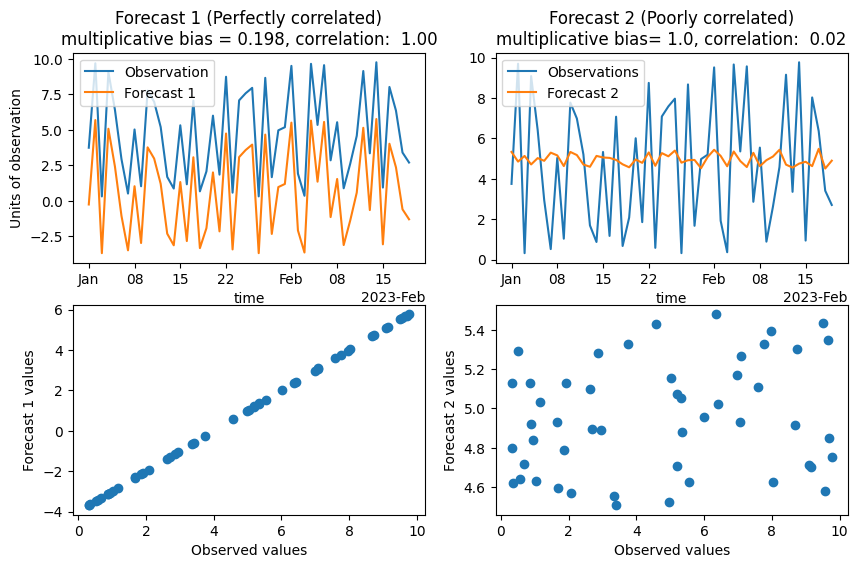

In [7]:
# Let's view a time series of both forecasts and observations for a single point
import math


fig,axs = plt.subplots(2,2,figsize=(10,6))
obs.sel(x=0).drop_vars(["x"]).plot(ax=axs[0,0],label='Observation')
fcst1.sel(x=0).drop_vars(["x"]).plot(ax=axs[0,0],label='Forecast 1')
axs[0,0].set_ylabel("Units of observation")
axs[0,0].legend()

obs.sel(x=0).drop_vars(["x"]).plot(ax=axs[0,1],label='Observations')
fcst2.sel(x=0).drop_vars(["x"]).plot(ax=axs[0,1],label='Forecast 2')
axs[0,1].legend()

# scatter plot
axs[1,0].scatter(obs.sel(x=0).values, fcst1.sel(x=0).values)
axs[1,0].set_ylabel("Forecast 1 values")
axs[1,0].set_xlabel("Observed values")

axs[1,1].scatter(obs.sel(x=0).values, fcst2.sel(x=0).values)
axs[1,1].set_ylabel("Forecast 2 values")
axs[1,1].set_xlabel("Observed values");

# let's calculate the bias and correlation of each forecast system
bias1 = multiplicative_bias(fcst1, obs).item()
bias2 = multiplicative_bias(fcst2, obs).item()

corr1 = pearsonr(fcst1, obs).item()
corr2 = pearsonr(fcst2, obs).item()

if math.isnan(corr1) or math.isnan(corr2):
    warnings.warn("Warning! The returned value from corr1 or corr2 is NaN\n")
else:
    axs[0,0].set_title(f"Forecast 1 (Perfectly correlated)\nmultiplicative bias = {bias1:.3}, correlation:  {corr1:.2f}")
    axs[0,1].set_title(f"Forecast 2 (Poorly correlated)\nmultiplicative bias= {bias2:.3}, correlation:  {corr2:.2f}");

    plt.show()

Recap from  [Pearson's correlation coefficient](Pearsons_Correlation.ipynb) tutorial:

- Forecast system 1 significantly underestimates the observations, producing predictions that are, on average, about 20% (multiplicative bias = 0.198) of the observed values. However, there is a perfect relationship between forecast 1 and observation data (Pearson correlation value = 1.0).
- Forecast system 2 aligns perfectly with the observed values on average (multiplicative bias = 1.0). However there is no correlation between the observation and forecast 2 (Pearson correlation value = 0.02)

Let us calculate the KGE and its component values for both forecast systems.

In [8]:
#Let's calculate the KGE of each forecast system
kge1 = kge(fcst1, obs, include_components=True)
kge2 = kge(fcst2, obs, include_components=True)
print(f"Forecast system 1: KGE = {kge1['kge'].item():.3}, correlation(rho) = {kge1['rho'].item():.3}, variability(alpha) = {kge1['alpha'].item():.3}, bias(beta) = {kge1['beta'].item():.3}")
print(f"Forecast system 2: KGE = {kge2['kge'].item():.3}, correlation(rho) = {kge2['rho'].item():.3}, variability(alpha) = {kge2['alpha'].item():.3}, bias(beta) = {kge2['beta'].item():.3}")

Forecast system 1: KGE = 0.198, correlation(rho) = 1.0, variability(alpha) = 1.0, bias(beta) = 0.198
Forecast system 2: KGE = -0.329, correlation(rho) = 0.0236, variability(alpha) = 0.0992, bias(beta) = 1.0


We can also cross check the correlation (rho) and bias (beta) components with Pearson correlation from `scores.continuous.correlation.pearsonr` and multiplicative bias from `scores.continuous.multiplicative_bias` .

In [9]:
# Cross checking correlation from scores.continuous.correlation.pearsonr
corr1 = pearsonr(fcst1, obs).item()
corr2 = pearsonr(fcst2, obs).item()
assert corr1 == kge1['rho'].item()
assert corr2 == kge2['rho'].item()

In [10]:
# Cross checking multiplicative bias from scores.continuous.multiplicative_bias
bias1 = multiplicative_bias(fcst1, obs).item()
bias2 = multiplicative_bias(fcst2, obs).item()
assert bias1 == kge1['beta'].item()
assert bias2 == kge2['beta'].item()

Forecast system 1 performs better in terms of KGE, with a KGE score of 0.198. It has a perfect correlation (rho = 1.0) and perfect variability (alpha = 1.0), but the bias component (beta = 0.198) indicates a significant underestimation of the observations. Despite the bias, the strong correlation and variability contribute to a higher KGE score.

On the other hand, Forecast system 2 has a perfect bias component (beta = 1.0), meaning the mean of the forecasts matches the mean of the observations. However, it suffers from a very low correlation (rho = 0.0236) and poor variability (alpha = 0.0992), resulting in a much lower KGE score of -0.329. This indicates that, although the bias is ideal, the poor correlation and variability significantly degrade its performance.

Therefore Forecast system 1 is better overall.

## Further Reading

- Gupta, H. V., Kling, H., Yilmaz, K. K., & Martinez, G. F. (2009). Decomposition of the mean squared error and NSE performance criteria: Implications for improving hydrological modeling. *Journal of Hydrology*, 377(1-2), 80-91. https://doi.org/10.1016/j.jhydrol.2009.08.003.
- Knoben, W. J. M., Freer, J. E., & Woods, R. A. (2019). Technical note: Inherent benchmark or not? Comparing Nash-Sutcliffe and Kling-Gupta efficiency scores. Hydrology and Earth System Sciences, 23(10), 4323-4331. https://doi.org/10.5194/hess-23-4323-2019.


## Things to Try Next
- Use the `preserve_dims` or `reduce_dims` option to provide the KGE in a less summarised version across the extra dimensions.
- Compute KGE scores with different scaling factors.